## PREPROCESSING

In [54]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

M = fetch_openml(data_id=24)
x, y = M.data, M.target

#! Convert the data to a pandas DataFrame
M_features_df = pd.DataFrame(x, columns=M.feature_names)
M_targets_df = pd.DataFrame(y, columns=['class'])

M_everything_df = pd.concat([M_features_df, M_targets_df], axis=1)
# print(M_everything_df.head())

'''
CONVERT TO NUMERICAL DATA
'''
from mapping import mapping
for column, mp in mapping.items():
    M_everything_df[column] = M_everything_df[column].replace(mp)
# print(M_everything_df.head())

le = LabelEncoder()
M_everything_df_encoded = M_everything_df.apply(le.fit_transform)

'''
CLEAN DATA; VERIFY WITH STANDARD DEVIATION AND MEAN
'''
# veil-type has std = mean = 0 
# remove veil-type column
M_everything_df_encoded = M_everything_df_encoded.drop(columns='veil-type')

# change to 1 to see std/mean outputs
if(0):
    print("standard deviations:")
    std = M_everything_df_encoded.std()
    print(std)
    print()
    print("mean:")
    mean = M_everything_df_encoded.mean()
    print(mean)

'''
SPLIT DATA
'''
# Now split and use the encoded DataFrame
train, test = train_test_split(M_everything_df_encoded, test_size=.2, random_state=42)

X_train = train.iloc[:,:-1].values
Y_train = train.iloc[:,-1].values

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values

# X_train, Y_train = make_blobs(n_samples=300, centers=2, n_features=2, cluster_std=6, random_state=11)

## *Plot the data*

[[-7.90664706e-01  5.85288689e+00]
 [-1.42278973e+01 -1.63273467e+01]
 [-7.02550174e+00 -1.91142706e+01]
 [-5.54723596e-01  5.73736868e-01]
 [-9.57083839e+00 -2.40273008e-01]
 [ 7.43746588e+00  3.04823550e+00]
 [-2.30052536e+00  1.14140272e+01]
 [-1.15747213e+01 -1.03937440e+01]
 [ 2.55774062e+00  1.37958294e+00]
 [-1.11517963e+01 -1.00409916e+01]
 [-6.44431400e+00 -1.15282834e+01]
 [-1.60535093e+00  8.13041943e+00]
 [-2.00097810e+00 -1.34659475e+01]
 [ 8.40562866e+00  6.22580441e+00]
 [ 5.49601367e+00  1.82514389e+00]
 [-2.17927845e+00 -3.49751328e+00]
 [-2.45244074e+00 -6.38120369e+00]
 [-1.19385803e+01 -1.73955755e+01]
 [ 2.36233434e+00  2.55012698e+00]
 [-4.61652357e+00 -1.19386845e+00]
 [ 1.34366291e+01  2.84032407e+00]
 [-3.53041243e+00  8.10242692e+00]
 [-1.06270904e+01 -9.89389062e+00]
 [-1.79169238e+00  6.71760966e+00]
 [ 6.88935126e+00  8.47810599e+00]
 [-9.37498909e+00 -6.58036367e+00]
 [-7.18392712e+00 -8.44391996e+00]
 [ 1.67766221e+00 -3.51484229e+00]
 [-1.64992716e+01 -1

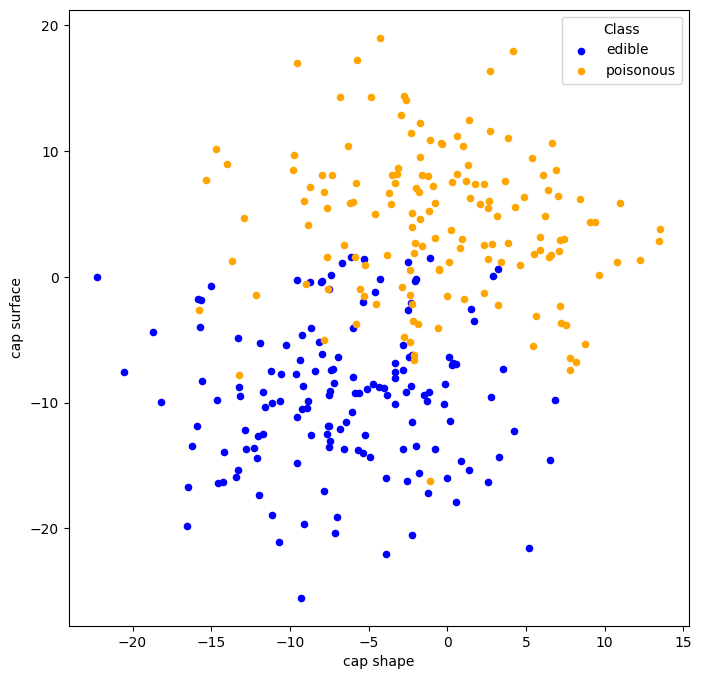

In [53]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import DataFrame 

X_train, Y_train = make_blobs(n_samples=300, centers=2, n_features=2, cluster_std=6, random_state=11)

df = DataFrame(dict(
    x=X_train[:,0], 
    y=X_train[:,1], 
    label=Y_train)
)
print(X_train)
print(df)

colors = {0:'blue', 1:'orange'}
fig, ax = plt.subplots(figsize=(8,8))
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.xlabel('cap shape')
plt.ylabel('cap surface')
plt.legend(title='Class', loc='upper right', labels=['edible', 'poisonous'])
plt.show()

## *Feature scaling*

In [44]:
def normalize(X):
    x1_min = min(X_train[:,0])
    x1_max = max(X_train[:,0])
    
    f = lambda x: (x - x1_min)/(x1_max - x1_min)
    X[:,0] = f(X[:,0])

    x2_min = min(X_train[:,1])
    x2_max = max(X_train[:,1])
    
    f = lambda x: (x - x2_min)/(x2_max - x2_min)
    X[:,1] = f(X[:,1])
    
    return X

In [45]:
X = normalize(X_train)
print(X[0:5])

[[0 1 7 0 8 1 0 1 2 1 4 3 2 5 7 2 1 0 7 4 6]
 [0 1 0 0 4 1 0 1 2 1 4 2 3 7 7 2 1 0 7 4 3]
 [0 0 7 0 3 1 0 1 2 1 4 3 3 5 7 2 1 0 7 4 1]
 [0 0 0 1 6 1 0 0 8 1 0 3 3 3 5 2 1 4 1 4 6]
 [0 0 9 1 1 1 0 0 0 0 1 3 3 7 7 2 1 4 1 2 2]]


## *Heart of KNN*

In [46]:
def find_neighbors(k, X_tr, new_point):
    neighbor_arr = []
    for i in range(len(X_tr)):
        dist = np.sqrt(sum(np.square(X_tr[i]-new_point)))
        neighbor_arr.append([i, dist])
    neighbor_arr = sorted(neighbor_arr, key = lambda x : x[1])
    
    return neighbor_arr[0:k]

## *Classification with KNN*

In [47]:
from collections import Counter
def classifier(neighbor_arr):
    class_arr = [Y_train[i[0]] for i in neighbor_arr]
    return Counter(class_arr).most_common(1)[0][0]

In [48]:
new_points = np.array([[-10, -10],
                      [0, 10],
                      [-15, 10],
                      [5, -2]])

new_points = normalize(new_points)

In [50]:
print(X[0:5])
print(new_points[0:5])
knn = find_neighbors(4, X, new_points[1])
classifier(knn)

[[0 1 7 0 8 1 0 1 2 1 4 3 2 5 7 2 1 0 7 4 6]
 [0 1 0 0 4 1 0 1 2 1 4 2 3 7 7 2 1 0 7 4 3]
 [0 0 7 0 3 1 0 1 2 1 4 3 3 5 7 2 1 0 7 4 1]
 [0 0 0 1 6 1 0 0 8 1 0 3 3 3 5 2 1 4 1 4 6]
 [0 0 9 1 1 1 0 0 0 0 1 3 3 7 7 2 1 4 1 2 2]]
[[-10 -10]
 [  0  10]
 [-15  10]
 [  5  -2]]


ValueError: operands could not be broadcast together with shapes (21,) (2,) 

## *Generate regression data*

In [ ]:
from sklearn.datasets import make_regression
X_train, Y_train = make_regression(n_samples=300, n_features=2, n_informative=2, noise=5, bias=30, random_state=200)

## *Plot the data*

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0],X_train[:,1],Y_train, c = "red",alpha=.5, marker = 'o')
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Y')
plt.show()

## *Regression with KNN*

In [ ]:
def regressor(neighbor_arr):
    y_arr = [Y_train[i[0]] for i in neighbor_arr]
    avg_y = np.mean(y_arr)
    return avg_y

In [ ]:
new_points = np.array([[-1, 1],
                      [0, 2],
                      [-3, -2],
                      [3, -3]])

knn = find_neighbors(3, X_train, new_points[1])
regressor(knn)